It's time to revisit your classifier from the previous assignment. Using the evaluation techniques we've covered here, look at your classifier's performance in more detail. Then go back and iterate by engineering new features, removing poor features, or tuning parameters. Repeat this process until you have five different versions of your classifier. Once you've iterated, answer these questions to compare the performance of each:

* Do any of your classifiers seem to overfit?
* Which seem to perform the best? Why?
* Which features seemed to be most impactful to performance?

Write up your iterations and answers to the above questions in a few pages. Submit a link below and go over it with your mentor to see if they have any other ideas on how you could improve your classifier's performance.

I chose the [yelp.com data](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences) to classify.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn
import seaborn as sns

In [2]:
raw_data = pd.read_csv('data/yelp_labelled.txt', delimiter='\t', encoding='latin-1',
                      header=None)
raw_data.columns = ['messages','review']

In [3]:
# Fixing display option to show complete messages
pd.set_option('display.max_colwidth', -1)

In [4]:
raw_data.tail(3)

,messages,review
997,Overall I was not impressed and would not go back.,0
998,"The whole experience was underwhelming, and I think we'll just go to Ninja Sushi next time.",0
999,"Then, as if I hadn't wasted enough of my life there, they poured salt in the wound by drawing out the time it took to bring the check.",0


In [5]:
df = raw_data.copy()

### Model 1 - Identifying Negative Messages

In [6]:
# Selecting negative keywords
keywords = ['avoid', 'bad', 'disappointed','nasty', 'overpriced', 'slow', 'tasteless','rude', 
            'undercooked', 'wasted', 'terrible', 'wasted','avoid','not ']

for key in keywords:
    df[str(key)] = df.messages.str.contains(
    '' + str(key) + '',
    case=False)

In [7]:
# Feature for detecting all caps messages
df['allcaps'] = df['messages'].str.isupper()

In [8]:
# Making negative reviews Trues
df['message'] = (df['review'] == 0)

In [9]:
df.head()

,messages,review,avoid,bad,disappointed,nasty,overpriced,slow,tasteless,rude,undercooked,wasted,terrible,not,allcaps,message
0,Wow... Loved this place.,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,Crust is not good.,0,False,False,False,False,False,False,False,False,False,False,False,True,False,True
2,Not tasty and the texture was just nasty.,0,False,False,False,True,False,False,False,False,False,False,False,True,False,True
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,The selection on the menu was great and so were the prices.,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [10]:
data = df[keywords + ['avoid']]
target = df['review']

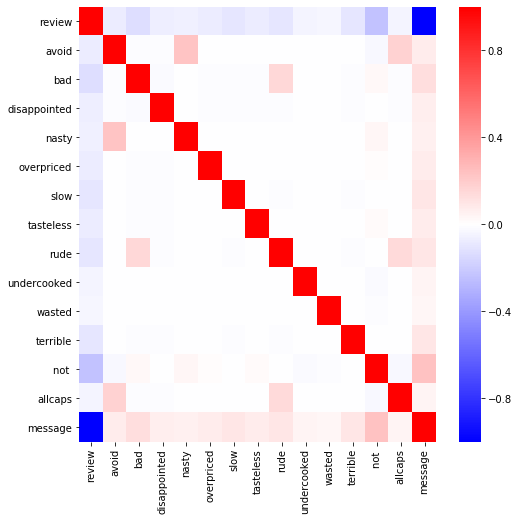

In [11]:
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(), center=0, cmap='bwr',vmax=1,vmin=-1)

#### Negative words with .2 or higher (not including message): Avoid, bad, nasty, rude, allcaps.  Let's see how the Bernoulli classifier is labeling this dataset.

In [12]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable
bnb = BernoulliNB()

# Fit our model to the data
y_pred = bnb.fit(data, target).predict(data)

# Display our results
print('Number of mislabeled reviews out of a total {} reviews: {}'.format(
    data.shape[0],
    (target != y_pred).sum()
))
print("Accuracy : {}%".format(
    bnb.score(data, target) * 100
))

Number of mislabeled reviews out of a total 1000 reviews: 356
Accuracy : 64.4%


In [13]:
df['message'].sample(5)

987    True 
382    False
240    True 
769    False
371    True 
Name: message, dtype: bool

In [14]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
results = confusion_matrix(target,y_pred)

print('CONFUSION MATRIX:')

print(results)
print('\n' + 'ACCURACTY SCORE:',accuracy_score(target, y_pred))

CONFUSION MATRIX:
[[166 334]
 [ 22 478]]

ACCURACTY SCORE: 0.644


In [15]:
# Test your model with different holdout groups.

from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

With 20% Holdout: 0.605
Testing on Sample: 0.644


In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(bnb, data, target, cv=10)

array([0.62, 0.64, 0.63, 0.59, 0.64, 0.67, 0.69, 0.65, 0.66, 0.64])

Testing with a 20% hold group comes out as 3.9% less with 20% holdout and identical on the testing sample.  And when cross validation is ran there is quite a variance among the scores from 0.59 to 0.69, so there is some overfitting going on.  

Let's change models and see if there are any changes.

### Model 2 - Gaussian Naive Bayes

Using the same keywords and dataset for second model.

In [17]:
data2 = df[keywords + ['avoid']]
target2 = df['review']

In [18]:
# Model 2 - Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

y_pred2 = gnb.fit(data2, target2).predict(data2)
print('Number of mislabeled reviews out of a total {} reviews: {}'.format(
    data2.shape[0],
    (target2 != y_pred2).sum()
))
print("Accuracy : {}%".format(
    gnb.score(data2, target2) * 100
))

Number of mislabeled reviews out of a total 1000 reviews: 434
Accuracy : 56.599999999999994%


In [19]:
# Model 2 - Create confusion matrix
results2 = confusion_matrix(target2,y_pred2)

print('CONFUSION MATRIX:')

print(results2)
print('\n' + 'ACCURACTY SCORE:',accuracy_score(target2, y_pred2))

CONFUSION MATRIX:
[[ 66 434]
 [  0 500]]

ACCURACTY SCORE: 0.566


In [20]:
# Model 2 - Test your model with different holdout groups.

from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train2, X_test2, y_train2, y_test2 = train_test_split(data2, target2, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(gnb.fit(X_train2, y_train2).score(X_test2, y_test2)))
print('Testing on Sample: ' + str(gnb.fit(data2, target2).score(data2, target2)))

With 20% Holdout: 0.545
Testing on Sample: 0.566


In [21]:
# Model 2 - cross validation
from sklearn.model_selection import cross_val_score
cross_val_score(gnb, data2, target2, cv=10)

array([0.56, 0.59, 0.54, 0.56, 0.55, 0.56, 0.57, 0.59, 0.57, 0.56])

Gaussian Naive Bayes model accuracy decreased from our first model (64.4% to 56.6%), however there does not seem to be as much overfitting as shown by the cross validation from 0.54 to 0.59.

Perhaps switching to a postive model might improve accuracy and lower overfitting versus the prior two models looking for negative messages.

### Model 3 - Identifying Positive Messages

In [22]:
# Model 3 Based on positive messages
df3 = raw_data.copy()

In [23]:
df3.head(3)

,messages,review
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0


In [24]:
# Model 3 - Selecting postive keywords
keywords3 = ['great','amazing','beautiful','mmmm','loved','wow','happier','good','delight',
            'best', 'quick','fresh','yummy','liked']

for key3 in keywords3:
    df3[str(key3)] = df3.messages.str.contains(
    '' + str(key3) + '',
    case=False)

In [25]:
data3 = df3[keywords3 + ['great']]
target3 = df3['review']

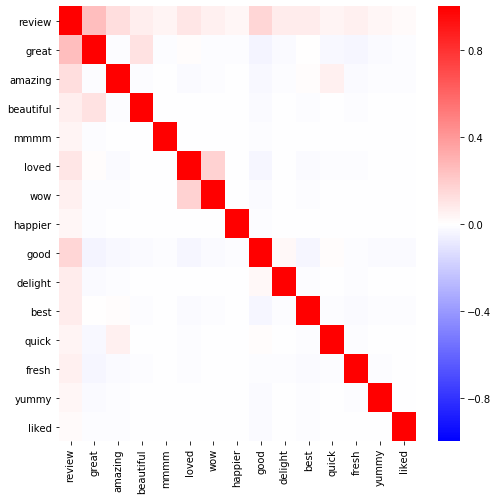

In [27]:
# Model 3
plt.figure(figsize=(8, 8))
sns.heatmap(df3.corr(), center=0, cmap='bwr',vmax=1,vmin=-1)

In [28]:
# Model 3 - Gaussian Naive Bayes
y_pred3 = gnb.fit(data3, target3).predict(data3)
print('Number of mislabeled reviews out of a total {} reviews: {}'.format(
    data2.shape[0],
    (target3 != y_pred3).sum()
))
print("Accuracy : {}%".format(
    gnb.score(data3, target3) * 100
))

Number of mislabeled reviews out of a total 1000 reviews: 389
Accuracy : 61.1%


In [29]:
# Model 3 - confusion matrix
results3 = confusion_matrix(target3,y_pred3)

print('CONFUSION MATRIX:')

print(results3)
print('\n' + 'ACCURACTY SCORE:',accuracy_score(target3, y_pred3))

CONFUSION MATRIX:
[[494   6]
 [383 117]]

ACCURACTY SCORE: 0.611


In [30]:
# Model 3 - Test your model with different holdout groups.

from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train3, X_test3, y_train3, y_test3 = train_test_split(data3, target3, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(gnb.fit(X_train3, y_train3).score(X_test3, y_test3)))
print('Testing on Sample: ' + str(gnb.fit(data3, target3).score(data3, target3)))

With 20% Holdout: 0.61
Testing on Sample: 0.611


In [31]:
cross_val_score(gnb, data3, target3, cv=10)

array([0.67, 0.56, 0.59, 0.59, 0.59, 0.57, 0.6 , 0.64, 0.58, 0.65])

My negative comment model was a little more successful at 64.4 though all models are fluctuating on the cross validation scores, so there is some overfitting. This is most likely due to not being able to take context of a sentence into consideration, such as some words can be in both types of reviews but have completely different meanings.

Since people are more likely to write a negative message, I'm going to try to improve the negative message model with additional features.

### Model 4

In [32]:
# Model 4 -  Based on negative messages
df4 = raw_data.copy()

I am going to adjust which of our previous words we used and add some new ones to improve the overall results.
'

In [33]:
# Model 4 - Selecting negative keywords'
keywords4 = ['angry','awful','avoid','avoided', 'bad', 'did not','disappointed','disgusted',
             'do not','nasty','no','not ','overpriced', 'rude','suck', 
             'terrible','wasted']

for key4 in keywords4:
    df4[str(key4)] = df4.messages.str.contains(
    '' + str(key4) + '',
    case=False)

In [34]:
# Feature for detecting all caps messages
df4['allcaps'] = df4['messages'].str.isupper()

In [35]:
# Making negative reviews Trues
df4['message'] = (df4['review'] == 0)

In [37]:
data4 = df4[keywords4 + ['angry']]
target4 = df4['review']

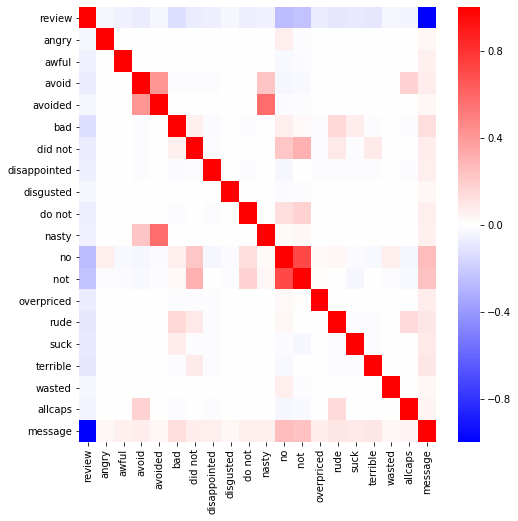

In [38]:
# Model 
plt.figure(figsize=(8, 8))
sns.heatmap(df4.corr(), center=0, cmap='bwr',vmax=1,vmin=-1)

You can see some strong correlation with avoid, avoided, nasty, no, and not.  But is there overfitting?

In [42]:
# Fit our model to the data
y_pred4 = bnb.fit(data4, target4).predict(data4)

# Display our results
print('Number of mislabeled reviews out of a total {} reviews: {}'.format(
    data4.shape[0],
    (target4 != y_pred4).sum()
))
print("Accuracy : {}%".format(
    bnb.score(data4, target4) * 100
))

Number of mislabeled reviews out of a total 1000 reviews: 338
Accuracy : 66.2%


The accuracy improved from 64.4, but is it actually better?

In [47]:
# Model 4 confusion matrix
results4 = confusion_matrix(target4,y_pred4)
print(results4)

[[212 288]
 [ 50 450]]


In [43]:
# Model 4 -Test your model with different holdout groups.

# Use train_test_split to create the necessary training and test groups
X_train4, X_test4, y_train4, y_test4 = train_test_split(data4, target4, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(bnb.fit(X_train4, y_train4).score(X_test4, y_test4)))
print('Testing on Sample: ' + str(bnb.fit(data4, target4).score(data4, target4)))

With 20% Holdout: 0.615
Testing on Sample: 0.662


In [44]:
# Model 4 - Cross Validation
cross_val_score(bnb, data, target, cv=10)

array([0.62, 0.64, 0.63, 0.59, 0.64, 0.67, 0.69, 0.65, 0.66, 0.64])

Again we have overfitting.  I believe because some of these words could easily be used in negative or positive reviews

In [50]:
# Comparing all negative review models (1, 2, & 4)
print('Model 1:\n', confusion_matrix(target, y_pred), '\n')
print('Model 2:\n', confusion_matrix(target2, y_pred2), '\n')
print('Model 4:\n', confusion_matrix(target4, y_pred4), '\n')

Model 1:
 [[166 334]
 [ 22 478]] 

Model 2:
 [[ 66 434]
 [  0 500]] 

Model 4:
 [[212 288]
 [ 50 450]] 



Out of all our models Model 2 came out on top with all the negative reviews correctly identified and 0 errors from failing to identify a negative review.